1. Физические характеристики крабов, найденных в районе Бостона. Они нужны для того, чтобы предугадать возраст краба
2. Все большая часть данных числовые. Есть один строковый тип - пол. В датасете представлены следующие атрибуты:
 - Sex - пол краба
 - Length - длина в футах
 - Diameter - диаметр в футах
 - Height - высота в футах
 - Weight - вес в унциях
 - Shucked Weight - вес без панциря в унциях
 - Viscera Weight - вес внутренностей в унциях
 - Shell Weight - вес панциря в унциях
 - Age - возраст

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans

df = pd.read_csv('CrabAgePrediction.csv')
df.head(10)

Добавим новый атрибут "Длина в метрах". Для этого умножим имеющуюся длину в футах на 0,305

In [174]:
df['Length in meters'] = df['Length'] * 0.305
df

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
0,F,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,9,0.438437
1,M,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,6,0.270687
2,I,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,6,0.316438
3,F,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,10,0.358375
4,I,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,6,0.270687
...,...,...,...,...,...,...,...,...,...,...
3888,F,1.4625,1.1375,0.3250,24.819987,11.651644,5.854172,6.378637,8,0.446062
3889,F,1.5500,1.2125,0.4375,34.458817,15.450477,7.172423,9.780577,10,0.472750
3890,I,0.6250,0.4625,0.1625,2.012815,0.765436,0.524466,0.637864,5,0.190625
3891,I,1.0625,0.7750,0.2625,10.347568,4.507570,2.338834,2.976698,6,0.324062


Проверим датасет на наличие дубликатов

In [175]:
df[df.duplicated()]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters


Дубликатов нет, но если бы они были, мы могли бы их удалить с помощью df.drop_duplicates()

Проверим датасет на наличие пропущенных значений

In [ ]:
df.isna().sum()

Sex                 0
Length              0
Diameter            0
Height              0
Weight              0
Shucked Weight      0
Viscera Weight      0
Shell Weight        0
Age                 0
Length in meters    0
dtype: int64

Пропущенных значений нет

Проверим датасет на наличие выбросов

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3893 entries, 0 to 3892
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sex               3893 non-null   object 
 1   Length            3893 non-null   float64
 2   Diameter          3893 non-null   float64
 3   Height            3893 non-null   float64
 4   Weight            3893 non-null   float64
 5   Shucked Weight    3893 non-null   float64
 6   Viscera Weight    3893 non-null   float64
 7   Shell Weight      3893 non-null   float64
 8   Age               3893 non-null   int64  
 9   Length in meters  3893 non-null   float64
dtypes: float64(8), int64(1), object(1)
memory usage: 304.3+ KB


In [177]:
df_num = df.select_dtypes('float64')
df_num.head(10)

,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Length in meters
0,1.4375,1.1750,0.4125,24.635715,12.332033,5.584852,6.747181,0.438437
1,0.8875,0.6500,0.2125,5.400580,2.296310,1.374951,1.559222,0.270687
2,1.0375,0.7750,0.2500,7.952035,3.231843,1.601747,2.764076,0.316438
3,1.1750,0.8875,0.2500,13.480187,4.748541,2.282135,5.244657,0.358375
4,0.8875,0.6625,0.2125,6.903103,3.458639,1.488349,1.700970,0.270687
5,1.5500,1.1625,0.3500,28.661344,13.579410,6.761356,7.229122,0.472750
6,1.3000,1.0000,0.3250,17.704263,6.095142,5.854172,4.819415,0.396500
7,1.3250,1.0125,0.3750,23.572609,9.979024,5.301356,7.158249,0.404125
8,1.5875,1.2500,0.4125,42.212406,20.269893,9.766403,10.248344,0.484187
9,0.9125,0.6875,0.3375,6.803880,3.061746,1.261553,2.083688,0.278312


Так как все данные разные, стандартизируем их.
Столбец Age не берём в работу, так как значения в нем были спрогнозированы по физическим характеристикам

In [178]:
df_std = pd.DataFrame()
for col in df_num.columns:
  m = df_num[col].mean()
  s = df_num[col].std()
  df_std[col + '_n'] = (df_num[col] - m)/s
df_std.head(10)

,Length_n,Diameter_n,Height_n,Weight_n,Shucked Weight_n,Viscera Weight_n,Shell Weight_n,Length in meters_n
0,0.420045,0.620816,0.601337,0.076915,0.338581,0.144422,-0.012340,0.420045
1,-1.410660,-1.494136,-1.303856,-1.307784,-1.260667,-1.211802,-1.327949,-1.410660
2,-0.911377,-0.990576,-0.946632,-1.124110,-1.111585,-1.138740,-1.022411,-0.911377
3,-0.453701,-0.537372,-0.946632,-0.726149,-0.869890,-0.919552,-0.393364,-0.453701
4,-1.410660,-1.443780,-1.303856,-1.199621,-1.075443,-1.175271,-1.292003,-1.410660
5,0.794508,0.570460,0.005964,0.366712,0.537358,0.523434,0.109875,0.794508
6,-0.037631,-0.084168,-0.232185,-0.422067,-0.655302,0.231184,-0.501200,-0.037631
7,0.045583,-0.033812,0.244114,0.000384,-0.036384,0.053094,0.091902,0.045583
8,0.919329,0.922952,0.601337,1.342226,1.603524,1.491513,0.875515,0.919329
9,-1.327446,-1.343068,-0.113110,-1.206764,-1.138691,-1.248334,-1.194950,-1.327446


<ipython-input-179-9e5a336802c5>:3: UserWarning:

FixedFormatter should only be used together with FixedLocator



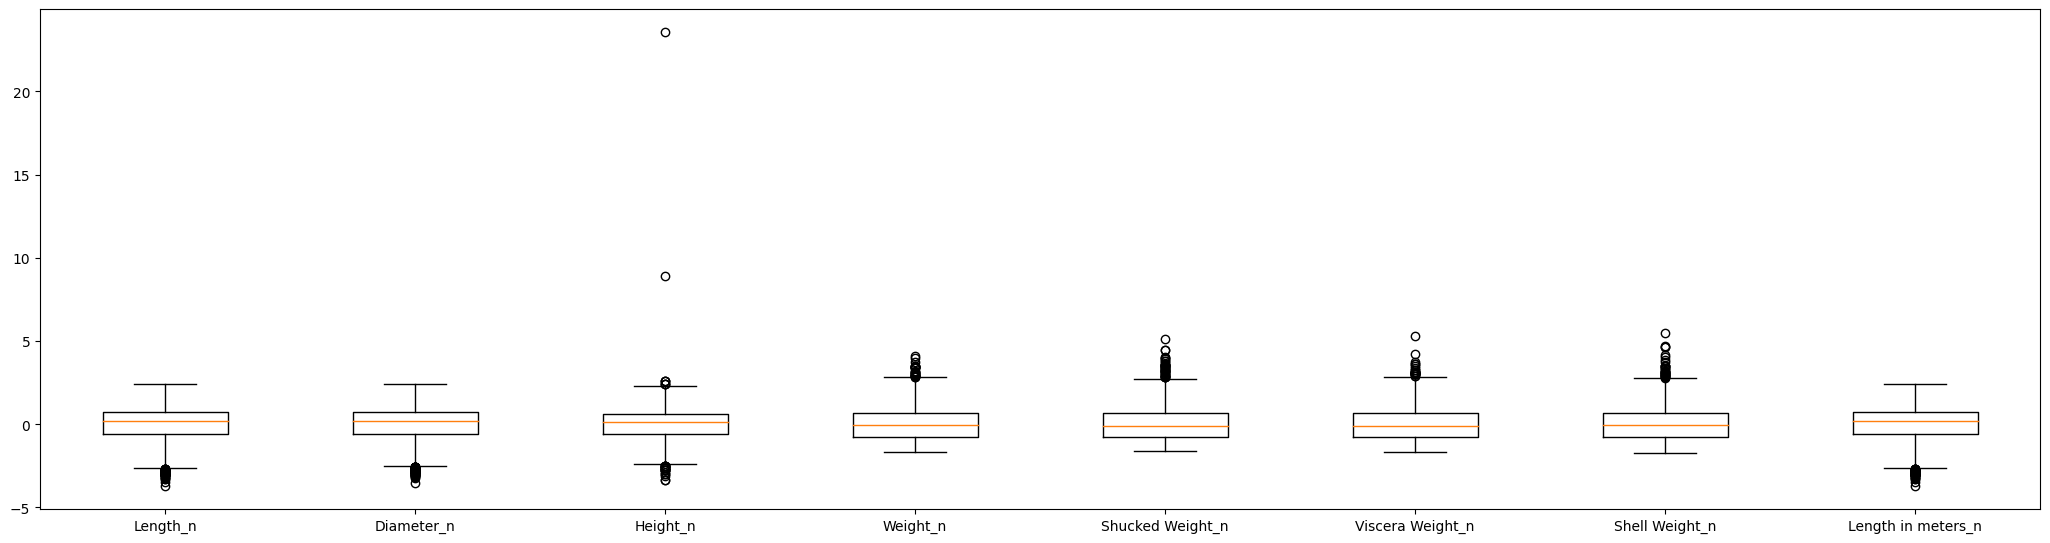

In [179]:
fig = plt.figure(figsize = (20, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(df_std.columns)

data = []
for col in df_std.columns:
  data.append(df_std[col])

bp = ax.boxplot(data, widths=0.5)
plt.show()

По хорошему стоит проверить измерения заново и скорректировать выбросы вручную, но такой возможности у нас нет.

Видим 2 аномальных наблюдения в столбце Height. Опустошим значения и заполним их с помощью k метода ближайших соседей.
Остальные значения близки к норме. Будем считать, что крабы с такими характеристиками встречаются чуть реже остальных

In [180]:
df['Height'].describe()

count    3893.000000
mean        0.349374
std         0.104976
min         0.000000
25%         0.287500
50%         0.362500
75%         0.412500
max         2.825000
Name: Height, dtype: float64

Видим, что минимальное значение нулевое, что странно. Тоже обработаем

In [181]:
df[df.Height == df.Height.max()]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
2256,F,1.1375,0.8875,2.825,16.839603,9.412034,3.288542,3.784658,8,0.346937


In [182]:
df[df.Height == df.Height.min()]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
269,I,0.7875,0.575,0.0,3.798833,1.630096,0.807961,9.936500,6,0.240187
3867,I,1.0750,0.850,0.0,12.133586,5.854172,2.438057,3.260193,8,0.327875


In [183]:
df.loc[(df.Height == df.Height.max()), 'Height'] = np.NaN
df.loc[(df.Height == df.Height.min()), 'Height'] = np.NaN
df[df.isna().sum(axis=1) > 0]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
269,I,0.7875,0.5750,NaN,3.798833,1.630096,0.807961,9.936500,6,0.240187
2256,F,1.1375,0.8875,NaN,16.839603,9.412034,3.288542,3.784658,8,0.346937
3867,I,1.0750,0.8500,NaN,12.133586,5.854172,2.438057,3.260193,8,0.327875


In [184]:
df['Height'].describe()

count    3890.000000
mean        0.348917
std         0.096900
min         0.025000
25%         0.287500
50%         0.362500
75%         0.412500
max         1.287500
Name: Height, dtype: float64

In [185]:
df[df.Height == df.Height.max()]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
748,M,1.7625,1.4125,1.2875,62.652395,31.397071,13.792032,14.514944,10,0.537562


In [186]:
df.loc[(df.Height == df.Height.max()), 'Height'] = np.NaN
df[df.isna().sum(axis=1) > 0]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
269,I,0.7875,0.5750,NaN,3.798833,1.630096,0.807961,9.936500,6,0.240187
748,M,1.7625,1.4125,NaN,62.652395,31.397071,13.792032,14.514944,10,0.537562
2256,F,1.1375,0.8875,NaN,16.839603,9.412034,3.288542,3.784658,8,0.346937
3867,I,1.0750,0.8500,NaN,12.133586,5.854172,2.438057,3.260193,8,0.327875


In [187]:
df['Height'].describe()

count    3889.000000
mean        0.348676
std         0.095736
min         0.025000
25%         0.287500
50%         0.362500
75%         0.412500
max         0.625000
Name: Height, dtype: float64

In [188]:
df_num = df.select_dtypes('float64')
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputer.fit(df_num)
df_num = pd.DataFrame(imputer.transform(df_num), index=df_num.index, columns=df_num.columns)
df['Height'] = df_num['Height']
df['Height'].describe()

count    3893.00000
mean        0.34866
std         0.09576
min         0.02500
25%         0.28750
50%         0.36250
75%         0.41250
max         0.62500
Name: Height, dtype: float64

Посмотрим, какие значения получились в результате импутации

In [189]:
df.loc[[269]]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
269,I,0.7875,0.575,0.225,3.798833,1.630096,0.807961,9.9365,6,0.240187


In [190]:
df.loc[[748]]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
748,M,1.7625,1.4125,0.5275,62.652395,31.397071,13.792032,14.514944,10,0.537562


In [191]:
df.loc[[2256]]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
2256,F,1.1375,0.8875,0.2975,16.839603,9.412034,3.288542,3.784658,8,0.346937


In [192]:
df.loc[[3867]]

,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Length in meters
3867,I,1.075,0.85,0.2825,12.133586,5.854172,2.438057,3.260193,8,0.327875


Посмотрим на выбросы ещё раз

<ipython-input-193-d94c8c1050ef>:9: UserWarning:

FixedFormatter should only be used together with FixedLocator



<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

<Figure size 2000x500 with 0 Axes>

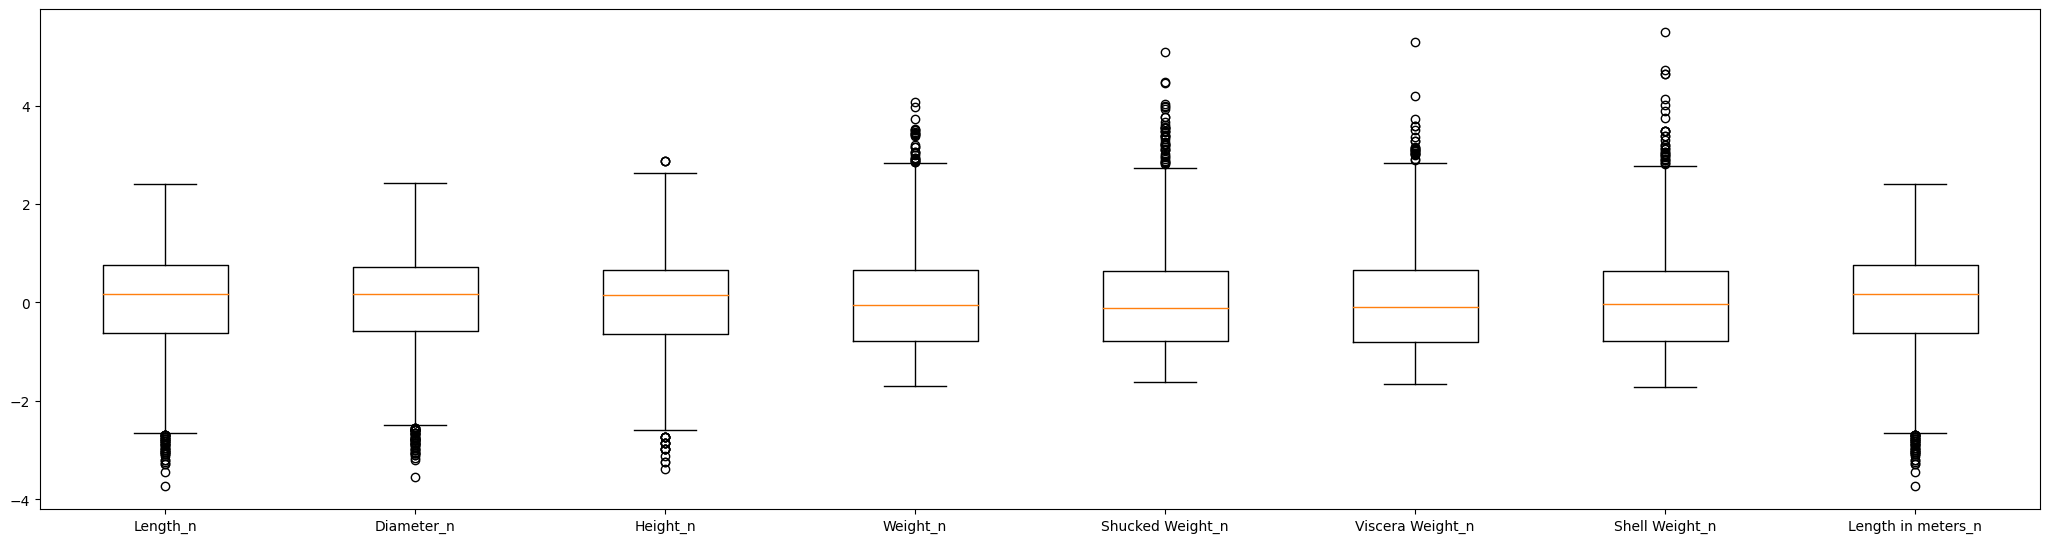

In [193]:
df_std = pd.DataFrame()
for col in df_num.columns:
  m = df_num[col].mean()
  s = df_num[col].std()
  df_std[col + '_n'] = (df_num[col] - m)/s

  fig = plt.figure(figsize = (20, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xticklabels(df_std.columns)

data = []
for col in df_std.columns:
  data.append(df_std[col])

bp = ax.boxplot(data, widths=0.5)
plt.show()

Построим графики зависимостей

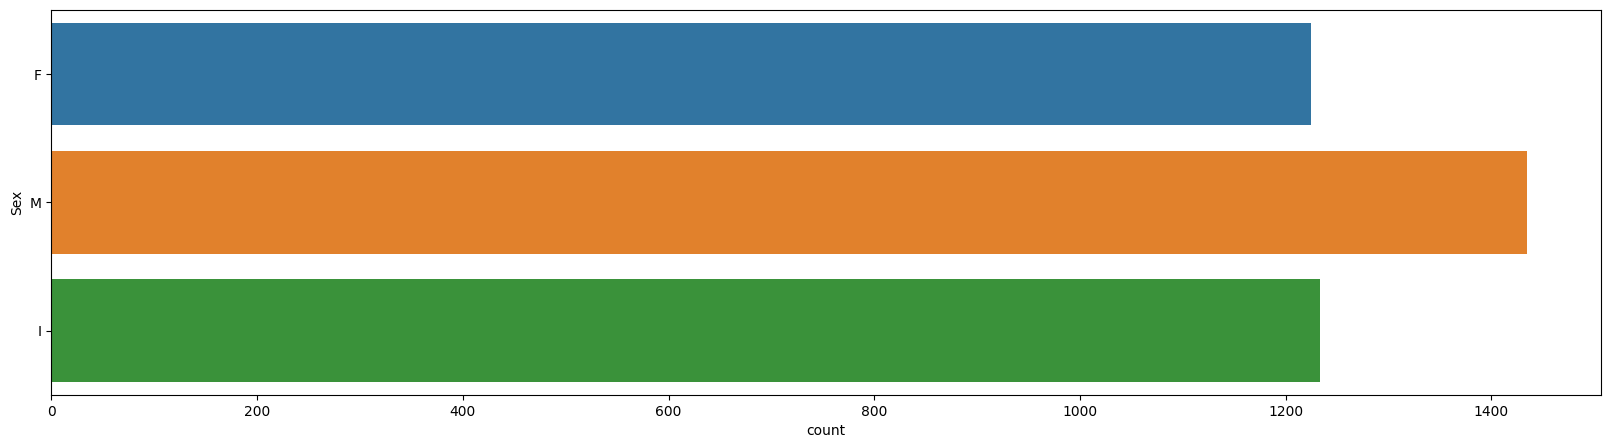

In [194]:
plt.figure(1 , figsize = (20 , 5))
sns.countplot(y = 'Sex' , data = df)
plt.show()

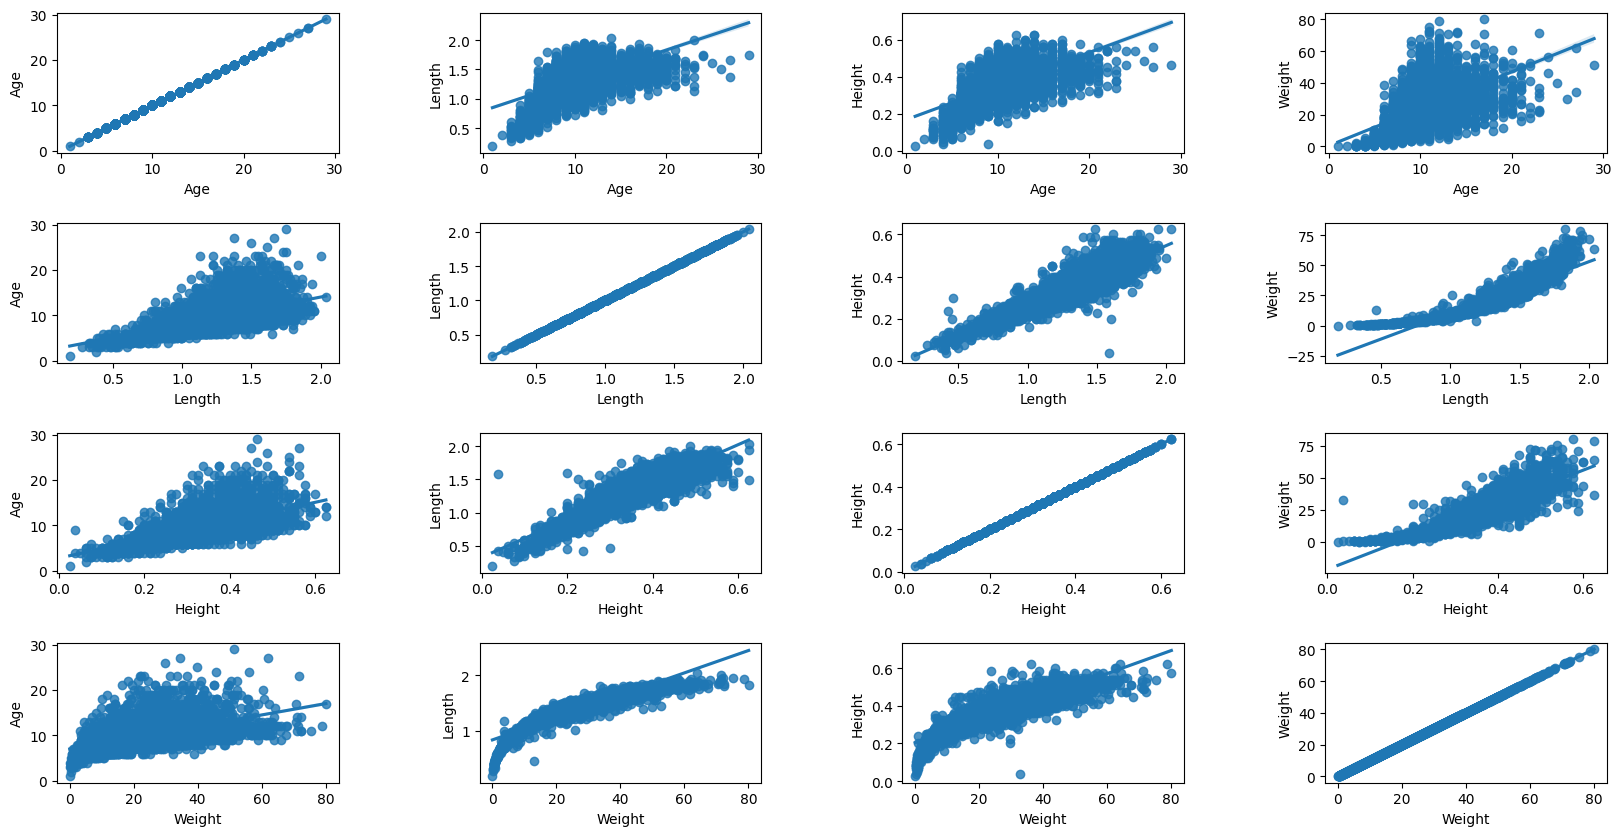

In [195]:
plt.figure(1, figsize = (20 , 10))
n = 0
for x in ['Age', 'Length', 'Height', 'Weight']:
    for y in ['Age', 'Length', 'Height', 'Weight']:
        n += 1
        plt.subplot(4, 4, n)
        plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
        sns.regplot(x = x, y = y, data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y)
plt.show()

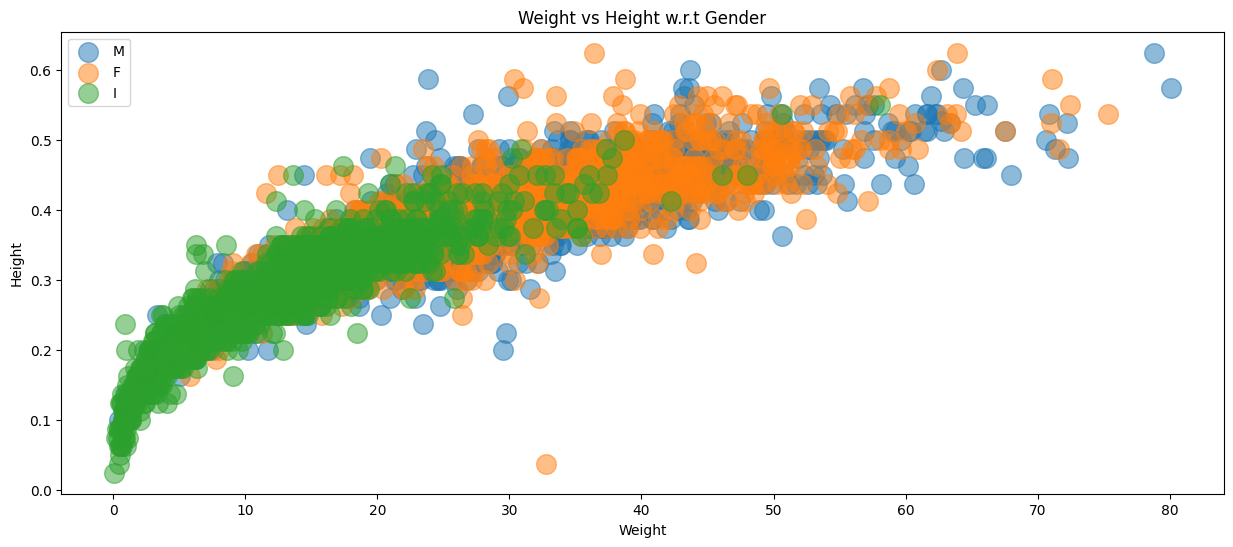

In [196]:
plt.figure(1, figsize = (15, 6))
for gender in ['M', 'F', 'I']:
    plt.scatter(x = 'Weight', y = 'Height', data = df[df['Sex'] == gender],
                s = 200, alpha = 0.5, label = gender)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.title('Weight vs Height w.r.t Gender')
plt.legend()
plt.show()

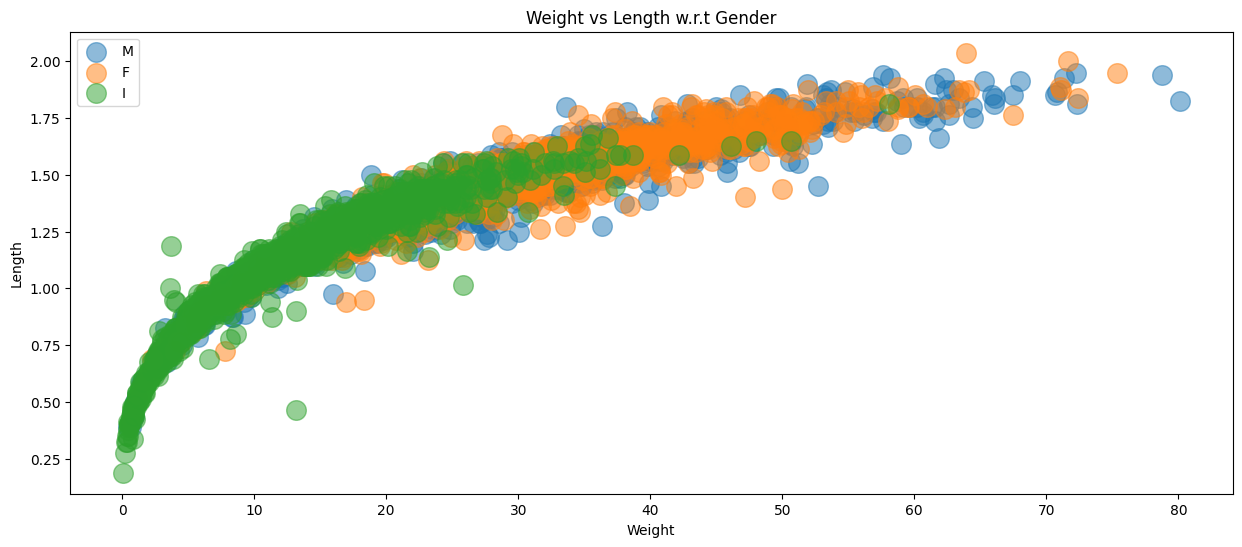

In [197]:
plt.figure(1 , figsize = (15, 6))
for gender in ['M', 'F', 'I']:
    plt.scatter(x = 'Weight', y = 'Length', data = df[df['Sex'] == gender],
                s = 200, alpha = 0.5, label = gender)
plt.xlabel('Weight')
plt.ylabel('Length')
plt.title('Weight vs Length w.r.t Gender')
plt.legend()
plt.show()

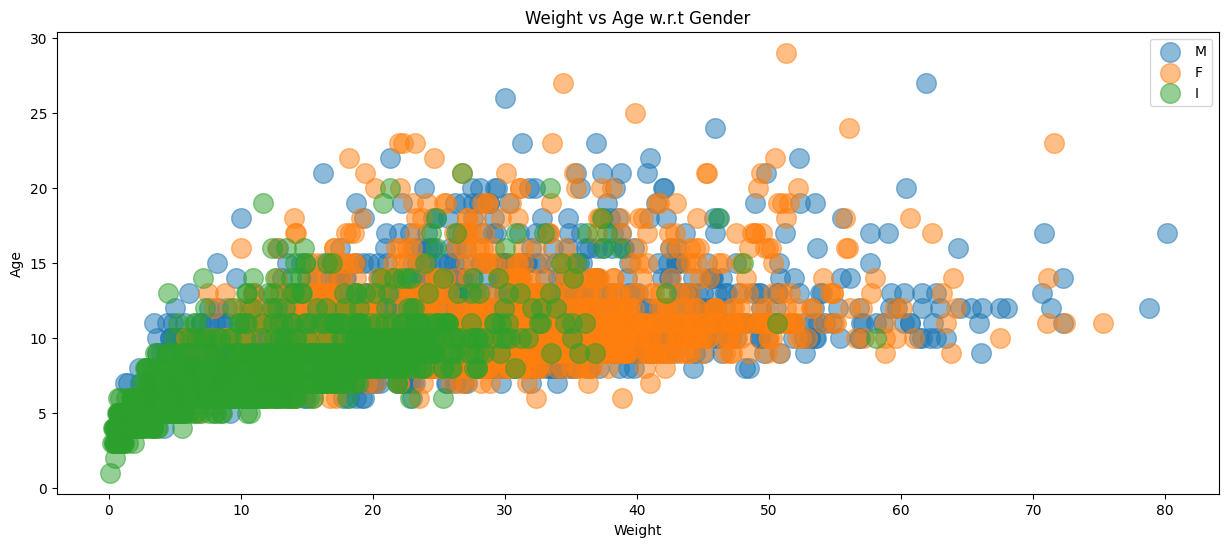

In [198]:
plt.figure(1 , figsize = (15, 6))
for gender in ['M', 'F', 'I']:
    plt.scatter(x = 'Weight', y = 'Age', data = df[df['Sex'] == gender],
                s = 200, alpha = 0.5, label = gender)
plt.xlabel('Weight')
plt.ylabel('Age')
plt.title('Weight vs Age w.r.t Gender')
plt.legend()
plt.show()

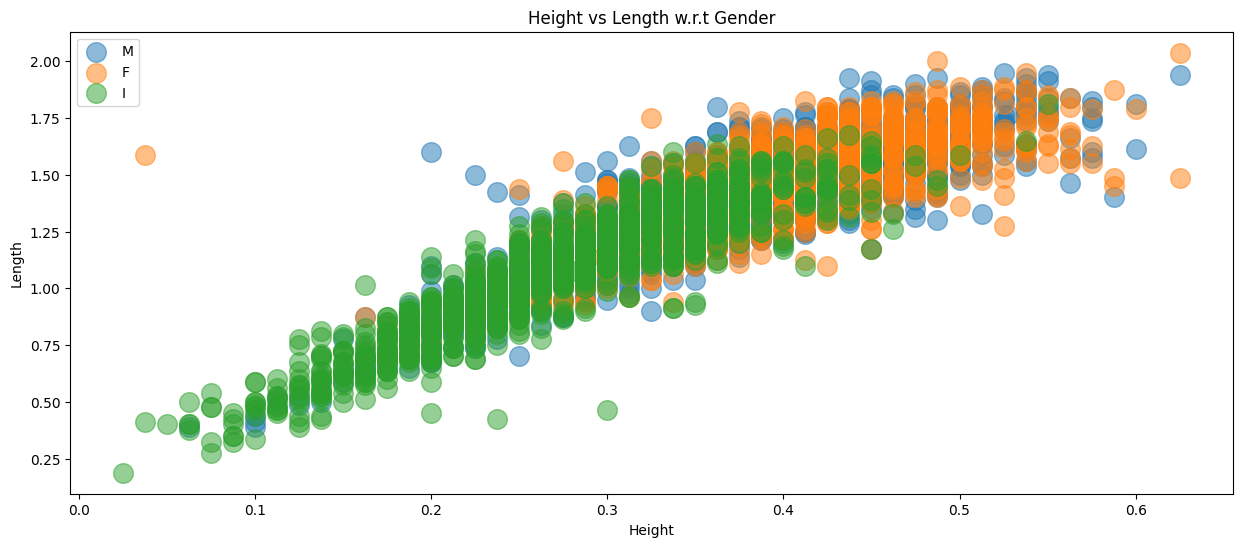

In [199]:
plt.figure(1 , figsize = (15, 6))
for gender in ['M', 'F', 'I']:
    plt.scatter(x = 'Height', y = 'Length', data = df[df['Sex'] == gender],
                s = 200, alpha = 0.5, label = gender)
plt.xlabel('Height')
plt.ylabel('Length')
plt.title('Height vs Length w.r.t Gender')
plt.legend()
plt.show()

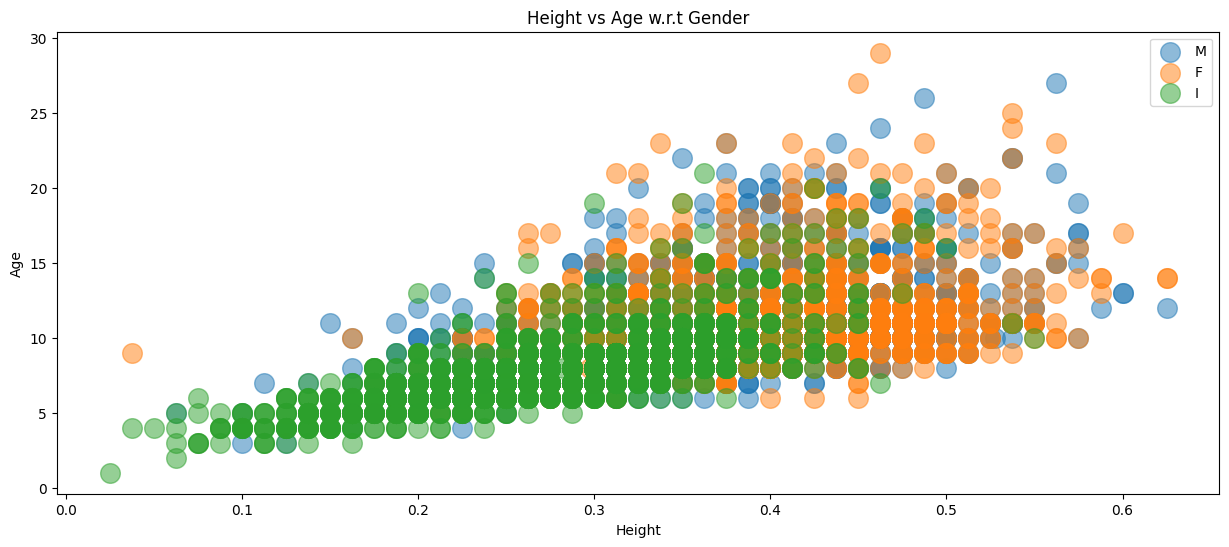

In [200]:
plt.figure(1 , figsize = (15, 6))
for gender in ['M', 'F', 'I']:
    plt.scatter(x = 'Height', y = 'Age', data = df[df['Sex'] == gender],
                s = 200, alpha = 0.5, label = gender)
plt.xlabel('Height')
plt.ylabel('Age')
plt.title('Height vs Age w.r.t Gender')
plt.legend()
plt.show()

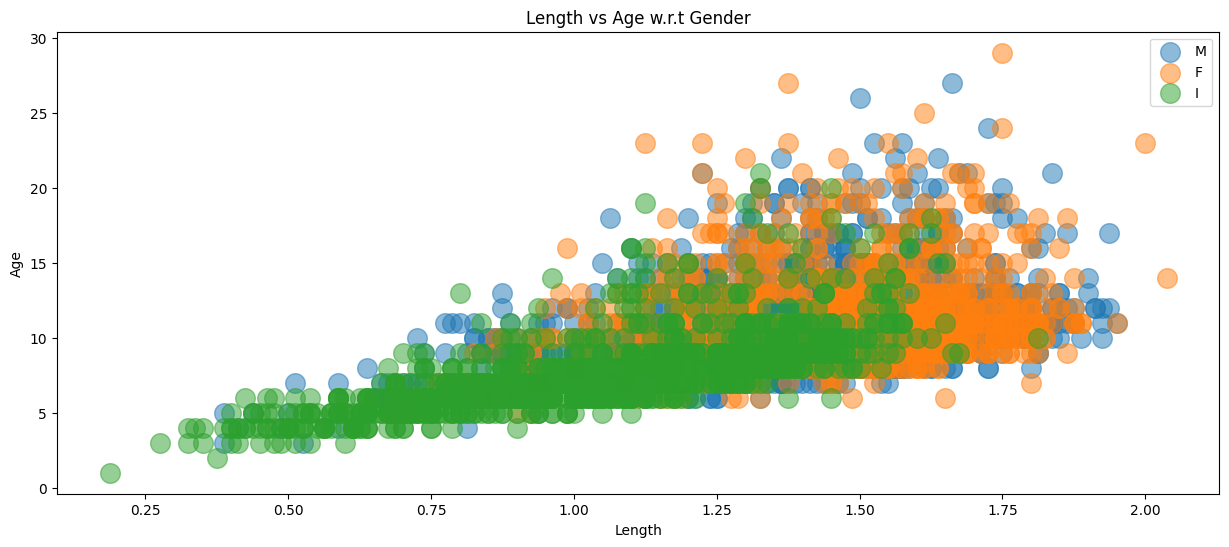

In [201]:
plt.figure(1 , figsize = (15, 6))
for gender in ['M', 'F', 'I']:
    plt.scatter(x = 'Length', y = 'Age', data = df[df['Sex'] == gender],
                s = 200, alpha = 0.5, label = gender)
plt.xlabel('Length')
plt.ylabel('Age')
plt.title('Length vs Age w.r.t Gender')
plt.legend()
plt.show()

Применим метод KMeans к набору данных

1. Вес и рост

In [202]:
X1 = df[['Weight', 'Height']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X1)
    inertia.append(algorithm.inertia_)

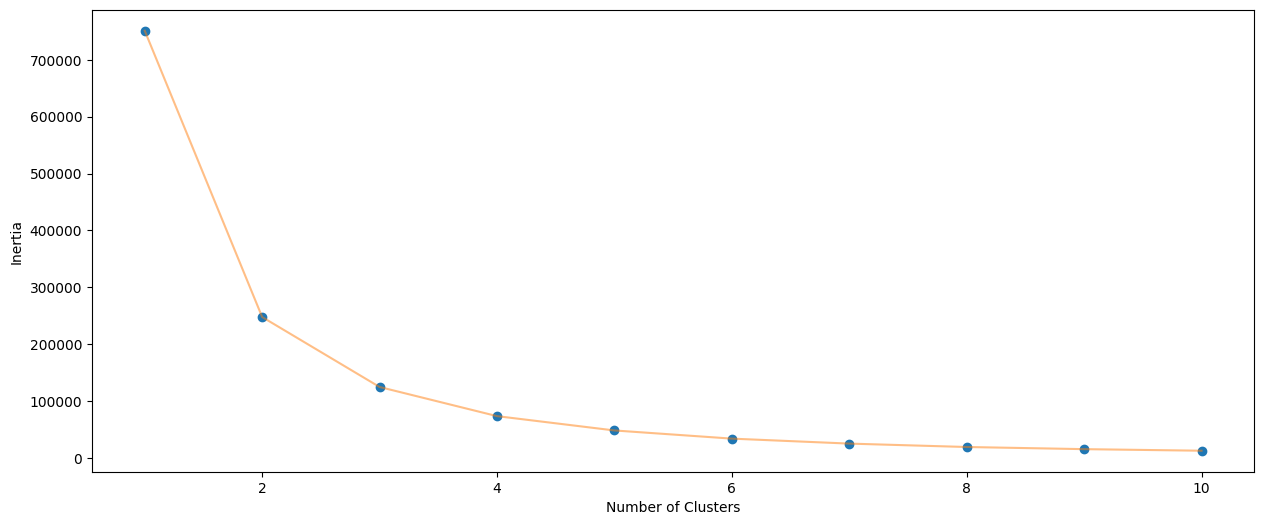

In [203]:
plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [204]:
algorithm = (KMeans(n_clusters = 7, init='k-means++', n_init = 10, max_iter = 300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X1)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [205]:
h = 0.02
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

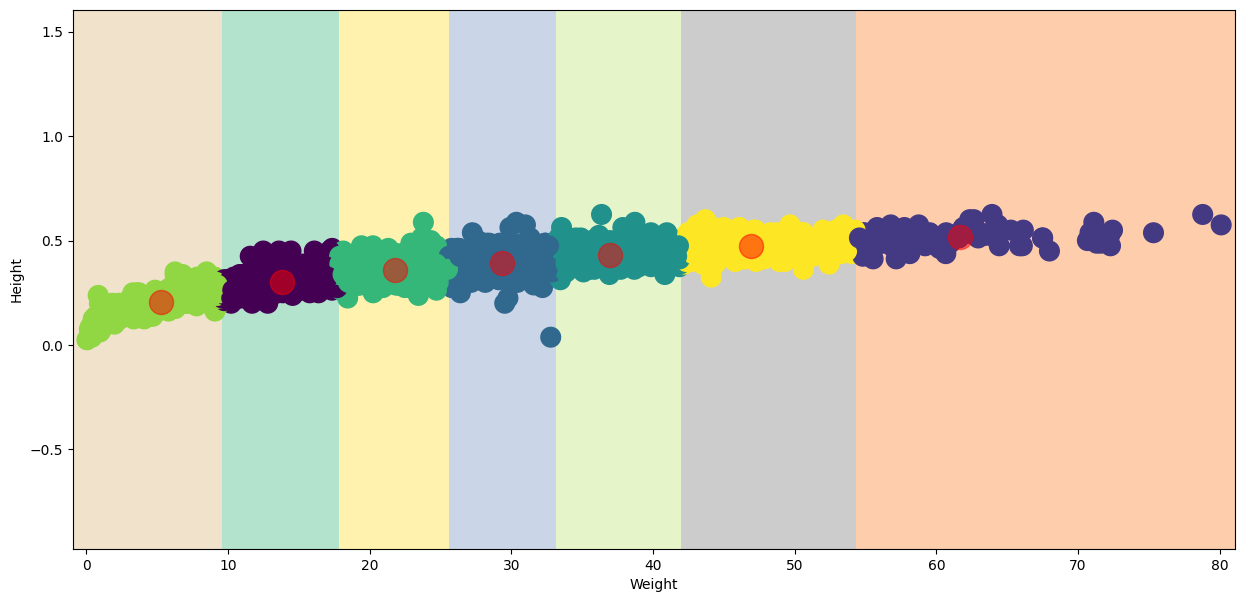

In [206]:
plt.figure(1, figsize = (15, 7))
plt.clf()
Z = Z.reshape(xx.shape)
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter( x='Weight', y ='Height', data = df, c = labels1, s = 200)
plt.scatter(x = centroids1[: , 0], y = centroids1[: , 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

2. Длина и вес

In [207]:
X2 = df[['Weight', 'Length']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111 , algorithm='lloyd'))
    algorithm.fit(X2)
    inertia.append(algorithm.inertia_)

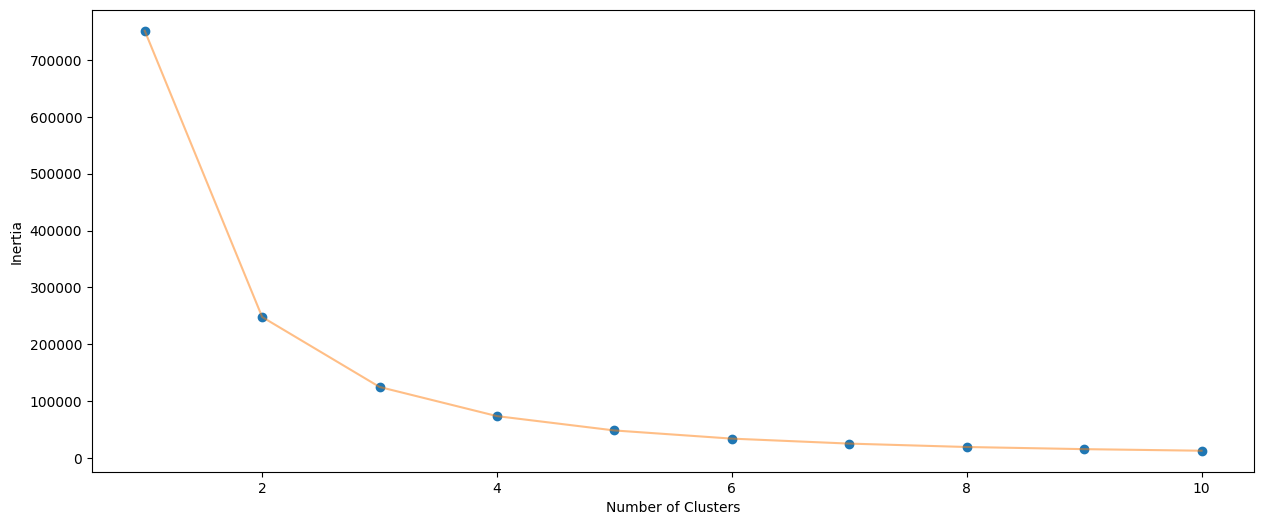

In [208]:
plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters'), plt.ylabel('Inertia')
plt.show()

In [209]:
algorithm = (KMeans(n_clusters = 7, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111 , algorithm='elkan'))
algorithm.fit(X2)
labels2 = algorithm.labels_
centroids2 = algorithm.cluster_centers_

In [210]:
h = 0.02
x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z2 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

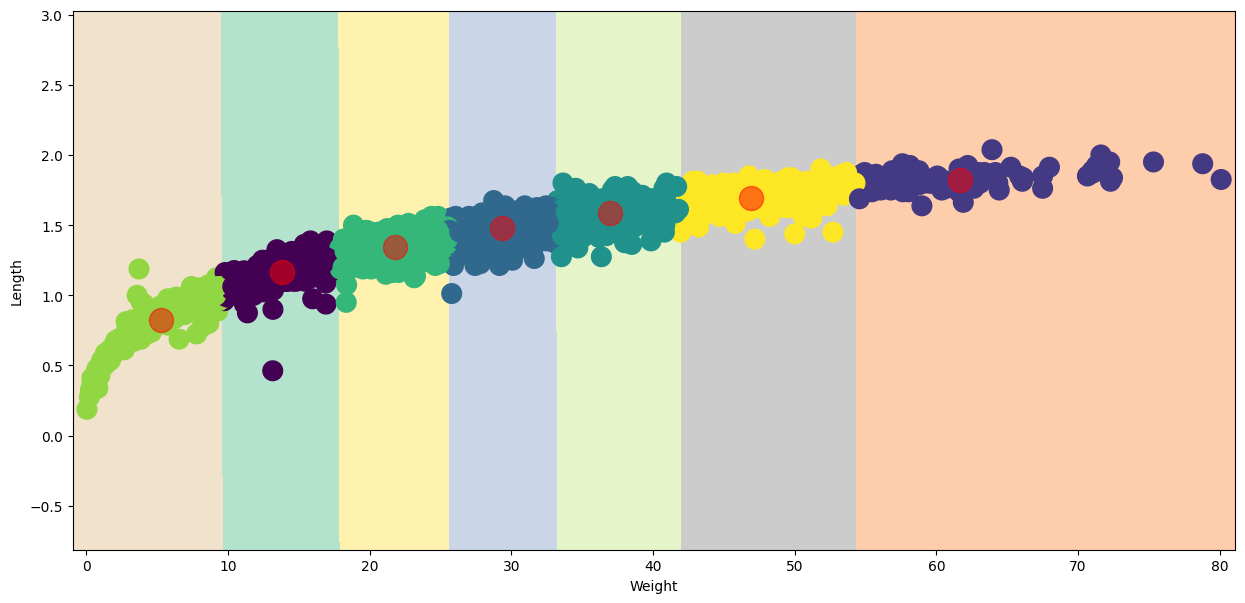

In [211]:
plt.figure(1, figsize = (15, 7))
plt.clf()
Z2 = Z2.reshape(xx.shape)
plt.imshow(Z2, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter(x = 'Weight', y = 'Length', data = df, c = labels2, s = 200 )
plt.scatter(x = centroids2[:, 0], y = centroids2[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Weight')
plt.ylabel('Length')
plt.show()

3. Вес и возраст

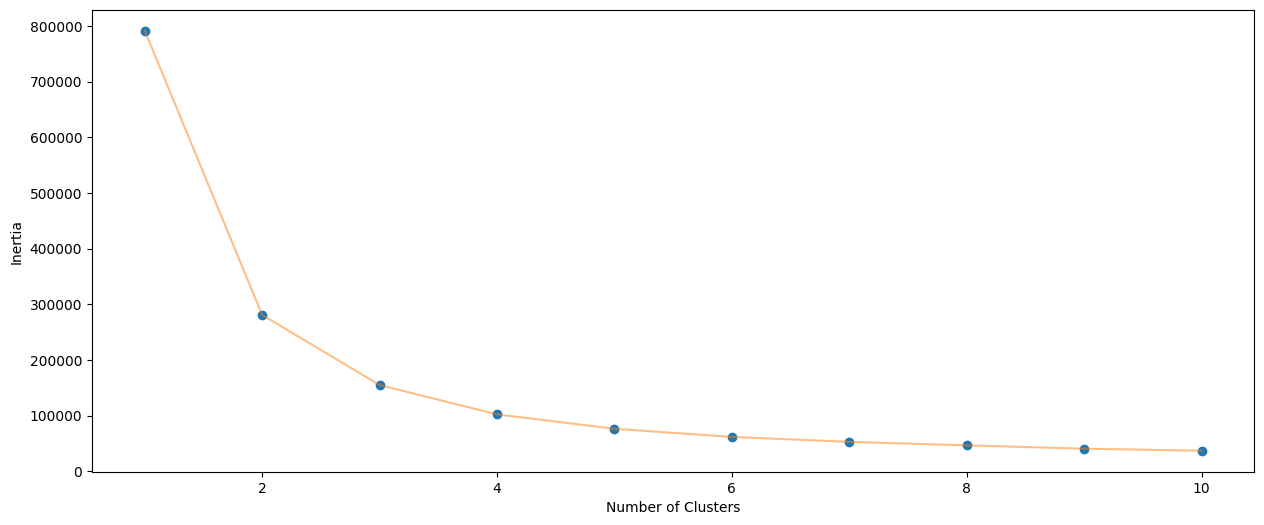

In [212]:
X3 = df[['Weight', 'Age']].iloc[: , :].values
inertia = []
for n in range(1, 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111 , algorithm='lloyd') )
    algorithm.fit(X3)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15 ,6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

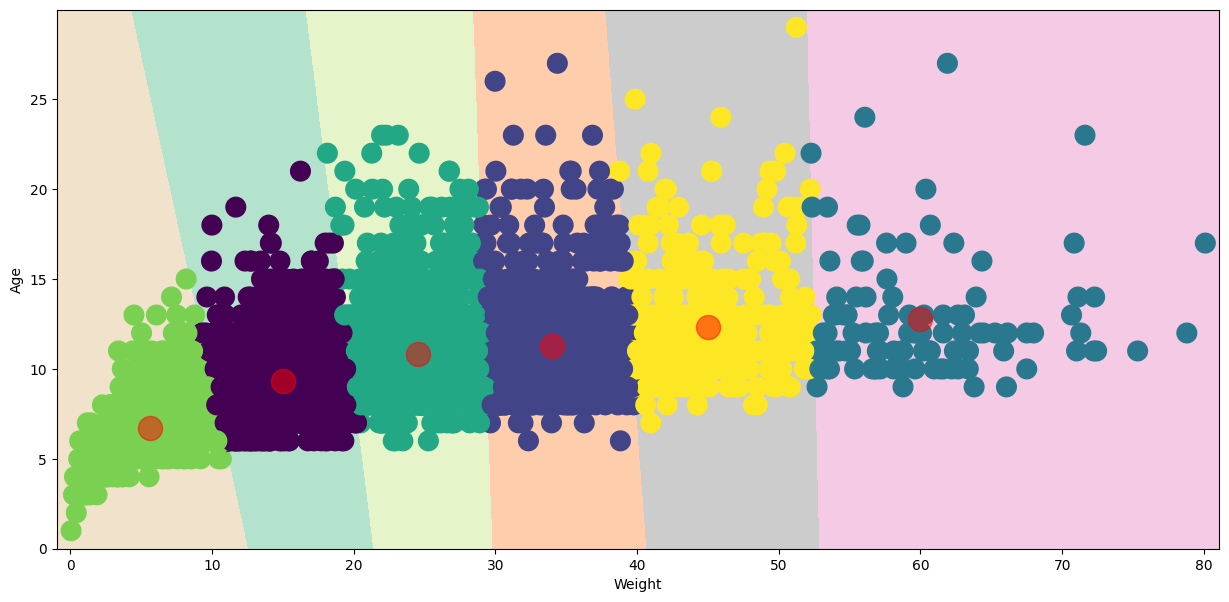

In [213]:
algorithm = (KMeans(n_clusters = 6, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='elkan'))
algorithm.fit(X3)
labels3 = algorithm.labels_
centroids3 = algorithm.cluster_centers_
h = 0.02
x_min, x_max = X3[:, 0].min() - 1, X3[:, 0].max() + 1
y_min, y_max = X3[:, 1].min() - 1, X3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z3 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z3 = Z3.reshape(xx.shape)
plt.imshow(Z3, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter(x = 'Weight', y = 'Age', data = df, c = labels3, s = 200 )
plt.scatter(x = centroids3[:, 0], y = centroids3[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Weight')
plt.ylabel('Age')
plt.show()

4. Рост и длина

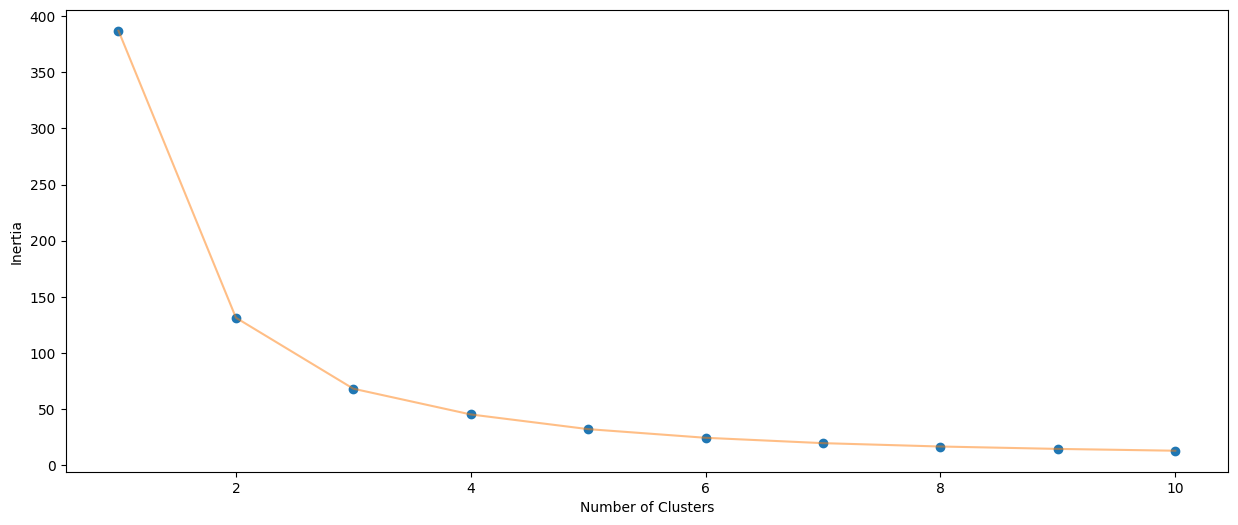

In [214]:
X4 = df[['Height', 'Length']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X4)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

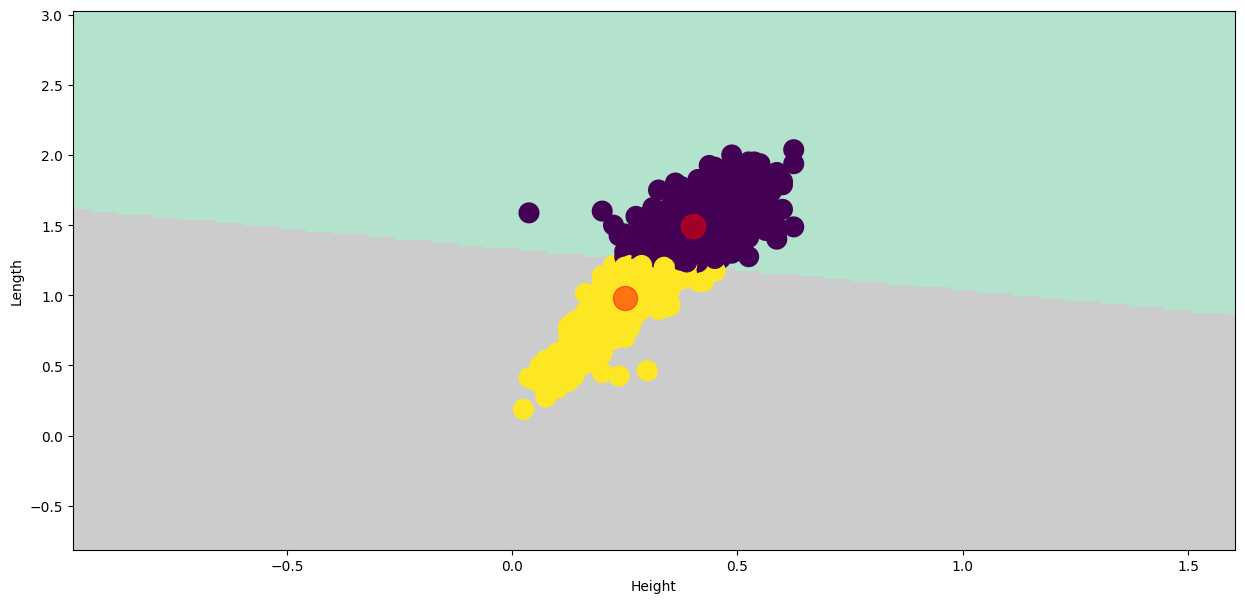

In [215]:
algorithm = (KMeans(n_clusters = 2, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X4)
labels4 = algorithm.labels_
centroids4 = algorithm.cluster_centers_
h = 0.02
x_min, x_max = X4[:, 0].min() - 1, X4[:, 0].max() + 1
y_min, y_max = X4[:, 1].min() - 1, X4[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z4 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z4 = Z4.reshape(xx.shape)
plt.imshow(Z4, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter(x = 'Height', y = 'Length', data = df, c = labels4, s = 200 )
plt.scatter(x = centroids4[:, 0], y = centroids4[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Height')
plt.ylabel('Length')
plt.show()

5. Рост и возраст

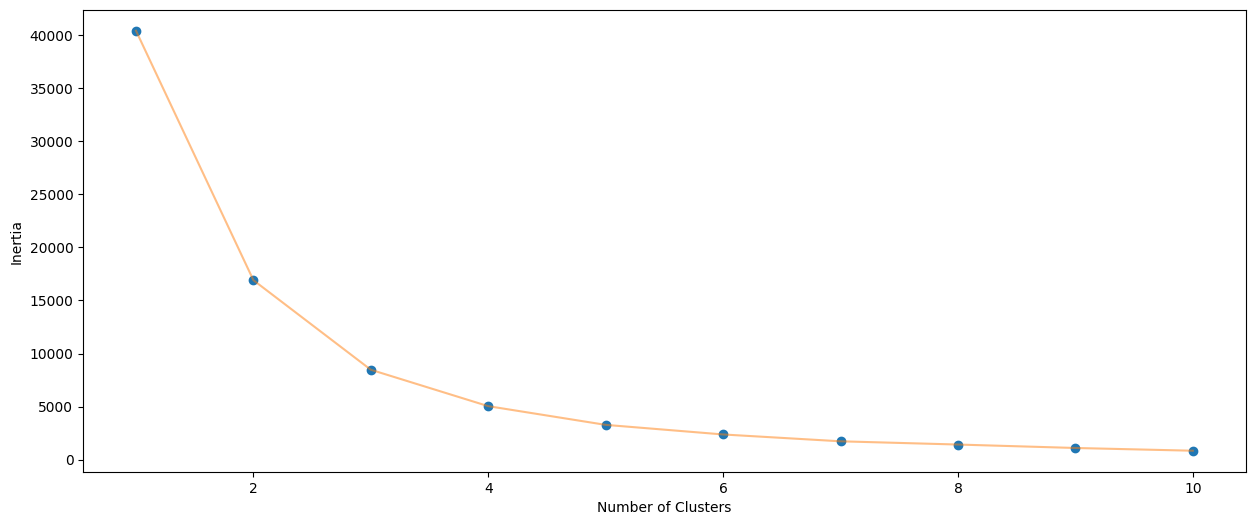

In [216]:
X5 = df[['Height', 'Age']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='lloyd') )
    algorithm.fit(X5)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

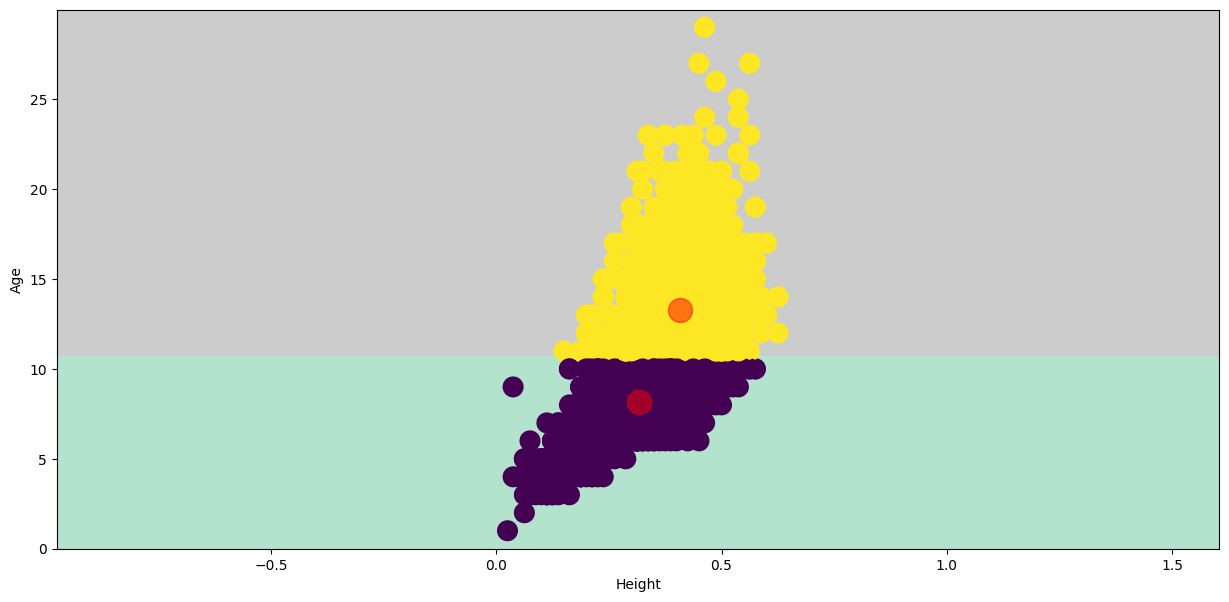

In [217]:
algorithm = (KMeans(n_clusters = 2, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X5)
labels5 = algorithm.labels_
centroids5 = algorithm.cluster_centers_
h = 0.02
x_min, x_max = X5[:, 0].min() - 1, X5[:, 0].max() + 1
y_min, y_max = X5[:, 1].min() - 1, X5[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z5 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z5 = Z5.reshape(xx.shape)
plt.imshow(Z5, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter(x = 'Height', y = 'Age', data = df, c = labels5, s = 200 )
plt.scatter(x = centroids5[:, 0], y = centroids5[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Height')
plt.ylabel('Age')
plt.show()

6. Длина и возраст

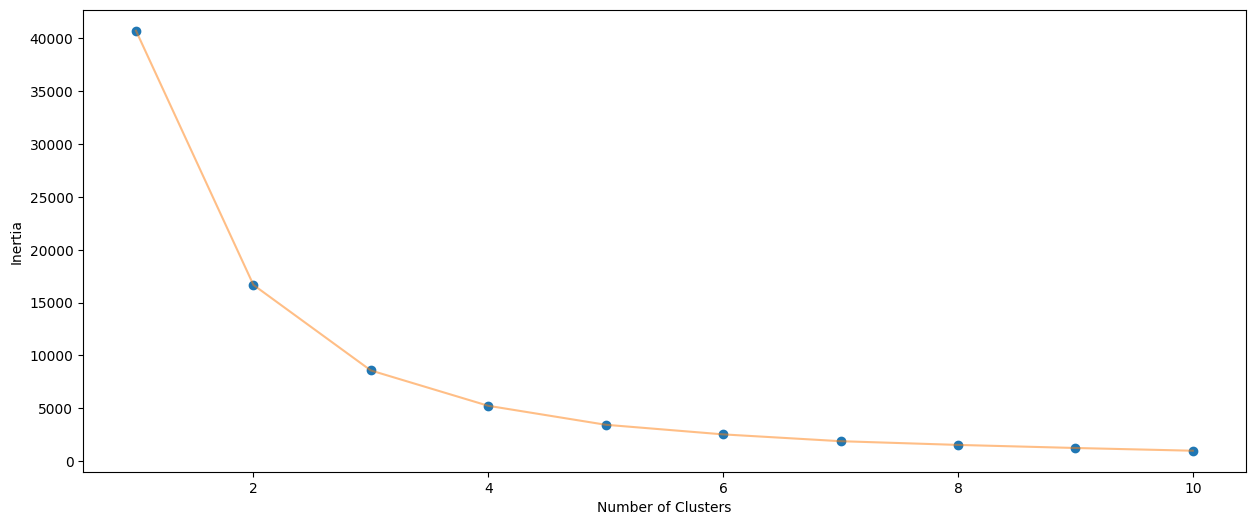

In [218]:
X6 = df[['Length', 'Age']].iloc[: , :].values
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n, init='k-means++', n_init = 10 , max_iter=300,
                        tol=0.0001,  random_state= 111 , algorithm='lloyd') )
    algorithm.fit(X6)
    inertia.append(algorithm.inertia_)

plt.figure(1, figsize = (15, 6))
plt.plot(np.arange(1, 11), inertia, 'o')
plt.plot(np.arange(1, 11), inertia, '-', alpha = 0.5)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

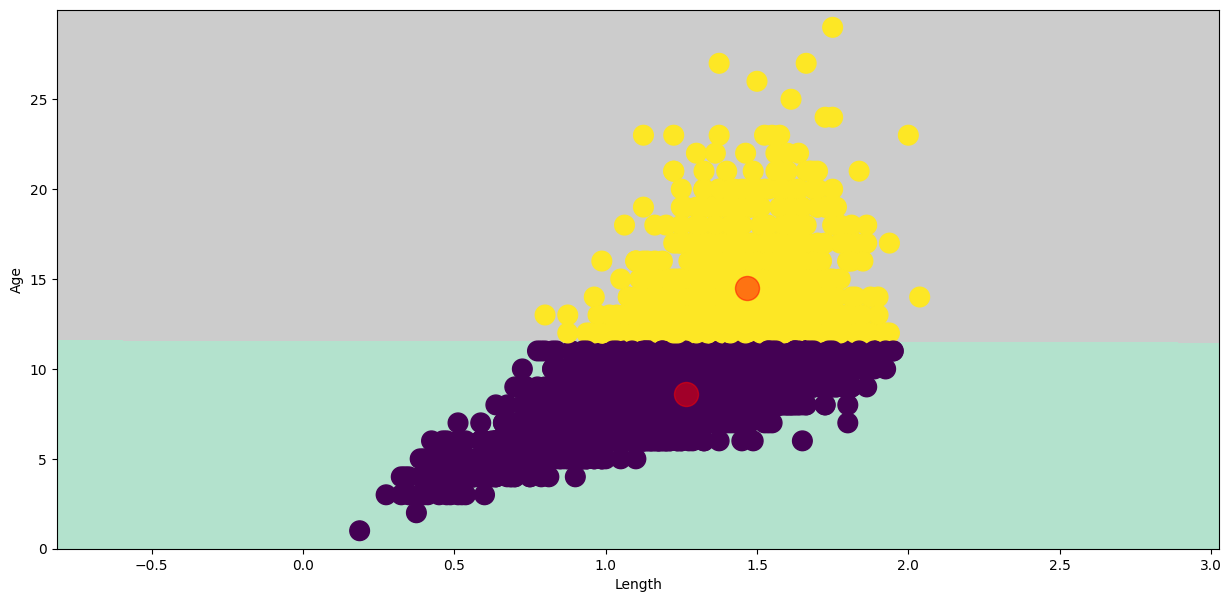

In [219]:
algorithm = (KMeans(n_clusters = 2, init='k-means++', n_init = 10, max_iter=300,
                        tol=0.0001,  random_state= 111, algorithm='elkan') )
algorithm.fit(X6)
labels6 = algorithm.labels_
centroids6 = algorithm.cluster_centers_
h = 0.02
x_min, x_max = X6[:, 0].min() - 1, X6[:, 0].max() + 1
y_min, y_max = X6[:, 1].min() - 1, X6[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z6 = algorithm.predict(np.c_[xx.ravel(), yy.ravel()])

plt.figure(1, figsize = (15, 7))
plt.clf()
Z6 = Z6.reshape(xx.shape)
plt.imshow(Z6, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Pastel2, aspect = 'auto', origin='lower')

plt.scatter(x = 'Length', y = 'Age', data = df, c = labels6, s = 200 )
plt.scatter(x = centroids6[:, 0], y = centroids6[:, 1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Length')
plt.ylabel('Age')
plt.show()